# Hydrological Timeseries Analysis

## Setup
### Package Import und Pfade

In [1]:
import pandas as pd
from scripts import dataio
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

basin_id = "12189500"

forcings_path = "./data/" + basin_id + "_lump_cida_forcing_leap.txt"
streamflow_path = "./data/" + basin_id + "_streamflow_qc.txt"

### Einladen der Daten

In [2]:
df_forcings_full = dataio.load_forcings(forcings_path)
df_forcings_full.head()

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
date,,,,,,,
1980-01-01,29648.11,26.54,45.61,0.0,0.21,-2.57,517.60
1980-01-02,29718.69,13.32,39.69,0.0,1.32,-1.04,571.68
1980-01-03,29721.60,23.99,82.86,0.0,0.28,-5.11,426.27
1980-01-04,29721.60,2.39,154.23,0.0,-0.68,-9.82,308.36
1980-01-05,29818.44,4.82,81.02,0.0,-3.30,-7.36,358.28


In [3]:
df_streamflow_full = dataio.load_streamflow(streamflow_path)
df_streamflow_full.head()

,gauge_id,streamflow,qc_flag
date,,,
1980-01-01,12189500,3270.0,A
1980-01-02,12189500,3210.0,A
1980-01-03,12189500,3020.0,A
1980-01-04,12189500,2730.0,A
1980-01-05,12189500,2580.0,A


Die Durchflusswerte müssen zunächst von ft^3/s in m^3/s umgewandelt werden.

In [4]:
factor = 35.315
df_streamflow_full["streamflow_unconverted"] = df_streamflow_full["streamflow"]
df_streamflow_full["streamflow"] = df_streamflow_full["streamflow_unconverted"] / factor

Anschließend wird ein Zeitraum für die nachfolgenden Analysen ausgewählt.

In [5]:
start_year = 2000
end_year = 2013

df_streamflow = df_streamflow_full[str(start_year):str(end_year)]
df_forcings = df_forcings_full[str(start_year):str(end_year)]

## Statistische Kennwerte für den Durchfluss
Die statistischen Kennwerte umfassen die gewässerkundlichen Hauptzahlen und werden aus längeren Messreihen (> 10 Jahre) abgeleitet.

| Hauptzahl | Bedeutung                        |
|-----------|----------------------------------|
| MQ        | mittlerer Abfluss                |
| HQ        | Hichwasserabfluss                |
| NQ        | Niedrigwasserabfluss             |
| HHQ       | Höchster Hochwasserabfluss       |
| NNQ       | Niedrigster Niedrigwasserabfluss |
| MHQ       | Mittlerer Hochwasserabfluss      |
| MNQ       | Mittlerer Niedrigwasserabfluss   |

In [6]:
mq = df_streamflow["streamflow"].mean()
nq = df_streamflow["streamflow"].min()
hq = df_streamflow["streamflow"].max()

hhq = df_streamflow_full["streamflow"].max()
nnq = df_streamflow_full["streamflow"].min()

# Jährliche Maxima durch jährliche Gruppierung der Werte und jeweilige Bestimmung des Maximums
yearly_maxs_stramflow = df_streamflow["streamflow"].groupby(df_streamflow.index.year).max()
# Mittelwert aller jährlichen Maxima
mhq = yearly_maxs_stramflow.mean()

# Jährliche Minima durch jährliche Gruppierung der Werte und jeweilige Bestimmung des Minimums
yearly_mins_stramflow = df_streamflow["streamflow"].groupby(df_streamflow.index.year).min()
# Mittelwert aller jährlichen Minima
mnq = yearly_mins_stramflow.mean()

summary_df = pd.DataFrame({"MQ": mq, "NQ": nq, "HQ": hq, "HHQ": hhq,
                           "NNQ": nnq, "MHQ": mhq, "MNQ": mnq}, index=[basin_id])

In [7]:
summary_df

,MQ,NQ,HQ,HHQ,NNQ,MHQ,MNQ
12189500,122.312335,18.264194,1540.421917,1979.328897,17.159847,875.993609,29.742521


## Auswertung des zeitlichen Verlaufs von Messwerten

Die Ganglinien unterschiedlicher Jahre lassen sich in einem Subplot darstellen. Die Ganglinie eines jeden Jahres wird so in einem eigenem Liniendiagramm dargestellt. Die unterschiedlichen Figuren werden jeweils in einem eigenen `Axes` Objekt gezeichnet. Diese lassen sich separat ansprechen.

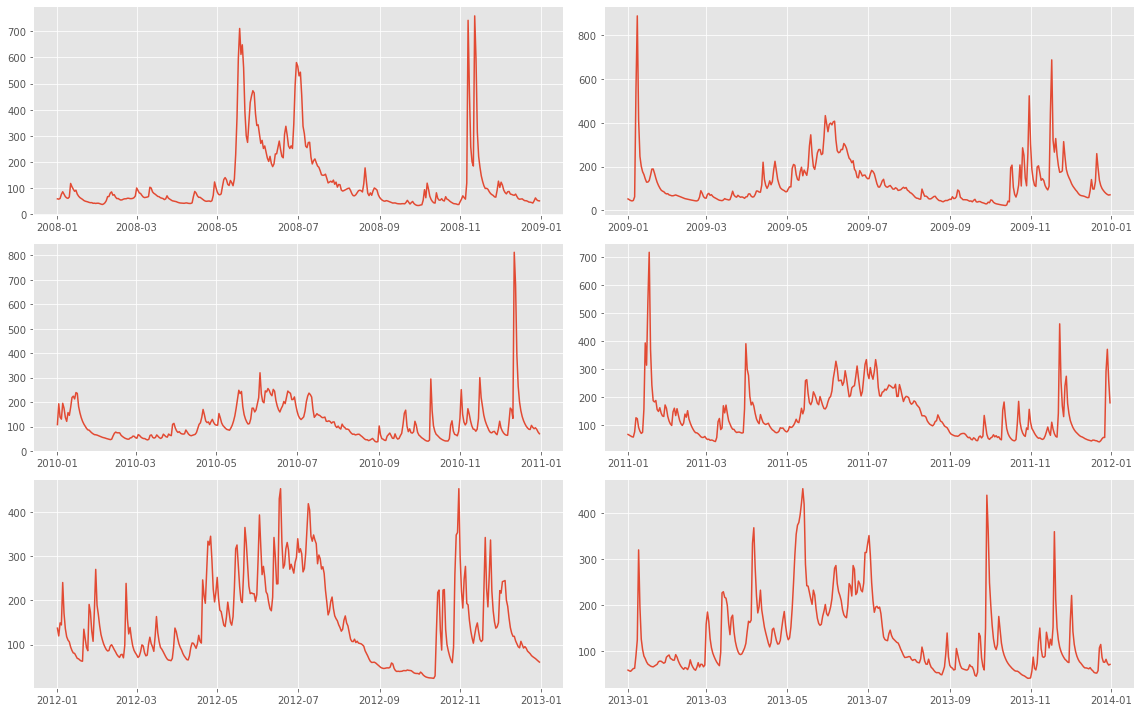

In [8]:
%matplotlib inline
plt.style.use('ggplot')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,10))
ax1.plot(df_streamflow.loc["2008"].index, df_streamflow["streamflow"].loc["2008"], label="2008")
ax2.plot(df_streamflow.loc["2009"].index, df_streamflow["streamflow"].loc["2009"], label="2009")
ax3.plot(df_streamflow.loc["2010"].index, df_streamflow["streamflow"].loc["2010"], label="2010")
ax4.plot(df_streamflow.loc["2011"].index, df_streamflow["streamflow"].loc["2011"], label="2011")
ax5.plot(df_streamflow.loc["2012"].index, df_streamflow["streamflow"].loc["2012"], label="2012")
ax6.plot(df_streamflow.loc["2013"].index, df_streamflow["streamflow"].loc["2013"], label="2013")
plt.tight_layout()

Über die einzelnen Axes Objekte lässt sich auch iterieren, was die Erstellung unseres Subplot etwas dynamischer werden lässt.

In [9]:
def plot_hydrograph_2(df: pd.DataFrame, dates: list):
    fig, axis_tuples = plt.subplots(3, 2, figsize=(16, 10))
    axis = [ax for ax_tupl in axis_tuples for ax in ax_tupl]
    for i in range(0, len(axis)):
        axis[i].plot(df_streamflow.loc[dates[i]].index, df_streamflow["streamflow"].loc[dates[i]], label=dates[i])
        axis[i].set_title("Jahr {0}".format(dates[i]))
        axis[i].set_ylabel('Durchfluss [m$^3$/s]')
        axis[i].set_xlabel('Datum')
    fig.suptitle("Ganglinien unterschiedlicher Jahre")
    plt.tight_layout()

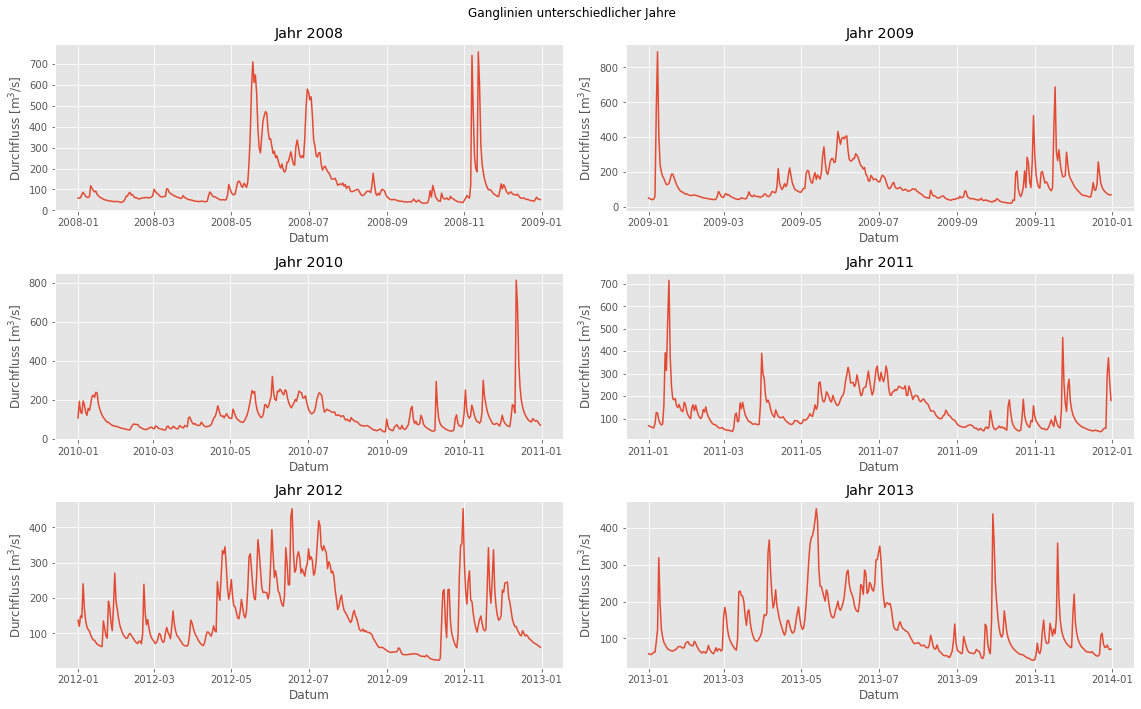

In [10]:
plot_hydrograph_2(df_streamflow, ["2008", "2009", "2010", "2011", "2012", "2013"])

Die Ganglinien verschiedener Jahre lassen sich auch in einem gemeinsamen Plot darstellen.

In [11]:
def plot_hydrograph_3(df: pd.DataFrame, dates: list):
    fig, ax = plt.subplots(figsize=(16, 10))
    for year in dates:
        ax.plot(df_streamflow.loc[year].reset_index().index, df_streamflow["streamflow"].loc[year], label=year)
    ax.set_xlabel('Tag im Jahr')
    ax.set_ylabel('Durchfluss [m$^3$/s]')
    ax.set_title("Ganglinien unterschiedlicher Jahre")
    ax.legend()
    plt.tight_layout()

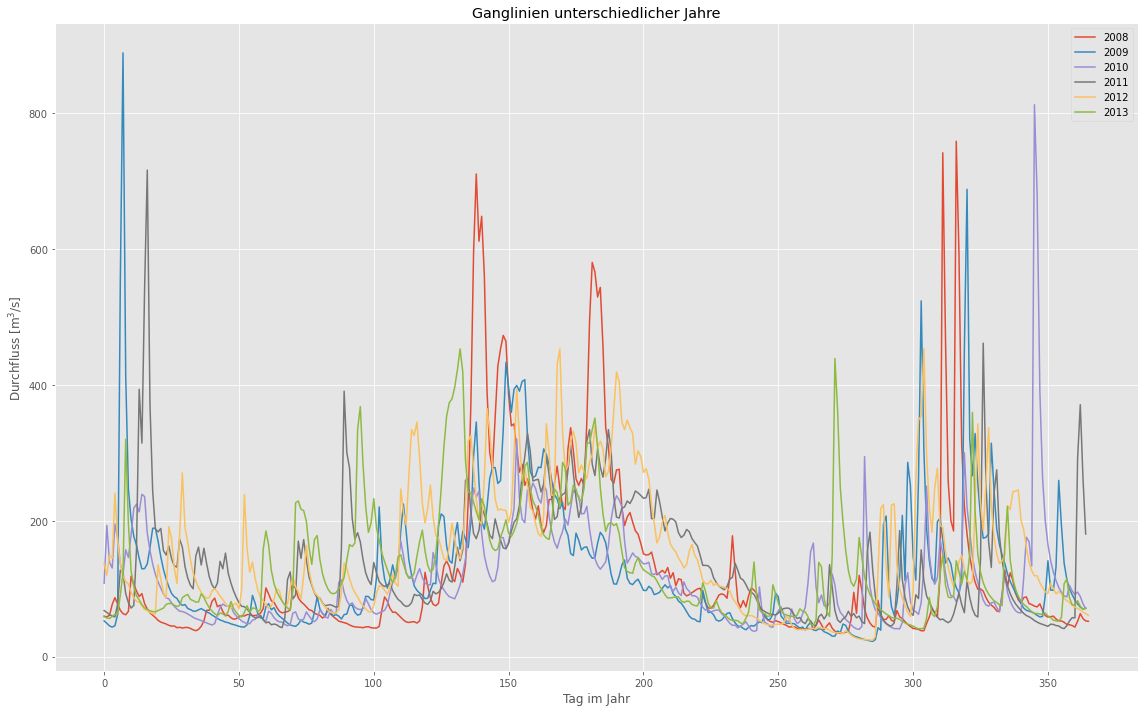

In [12]:
plot_hydrograph_3(df_streamflow, ["2008", "2009", "2010", "2011", "2012", "2013"])

## Intraannuelle Auswertung

Zunächst werden die monatlichen Mittelwerte über alle Jahre berechnet, indem nach Monaten gruppiert wird. Außerdem ermitteln wir hierfür die Standardabweichung, die wir anschließend auch im Plot verwenden.

In [13]:
streamflow_monthly_means = df_streamflow["streamflow"].groupby(df_streamflow.index.month).mean()
streamflow_monthly_std = df_streamflow["streamflow"].groupby(df_streamflow.index.month).std()

prcp_monthly_means = df_forcings["prcp(mm/day)"].groupby(df_forcings.index.month).mean()
prcp_monthly_std = df_forcings["prcp(mm/day)"].groupby(df_forcings.index.month).std()

month_names = ["Jan.", "Feb.", "März", "Apr.", "Mai", "Juni", "Juli", "Aug.", "Sept.", "Okt.", "Nov", "Dez."]

FÜr die Visualisierung der monatlichen Mittelwerte eignet sich ein Säulendiagramm, das mit Matplotlib als `bar`-Plot erstellt wird

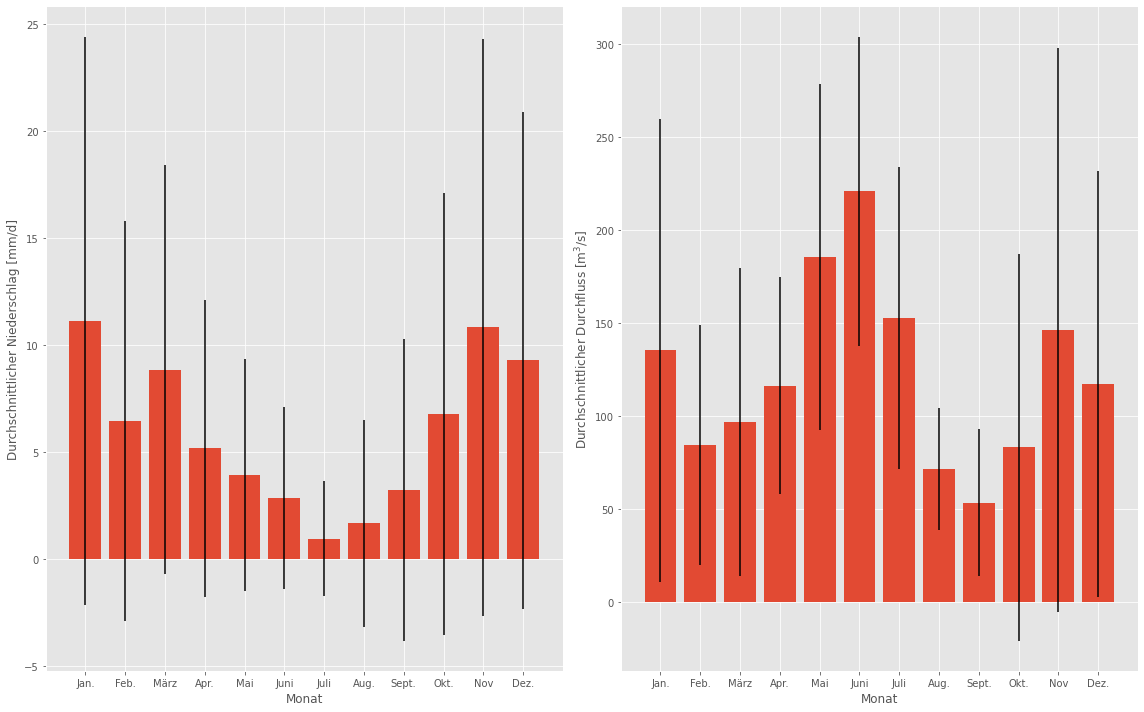

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
# Niederschlag
ax1.bar(prcp_monthly_means.index, prcp_monthly_means, yerr=prcp_monthly_std)
ax1.set_xticks(prcp_monthly_means.index)
ax1.set_xticklabels(month_names)
ax1.set_xlabel('Monat')
ax1.set_ylabel('Durchschnittlicher Niederschlag [mm/d]')

# Durchfluss
ax2.bar(streamflow_monthly_means.index, streamflow_monthly_means, yerr=streamflow_monthly_std)
ax2.set_xticks(streamflow_monthly_means.index)
ax2.set_xticklabels(month_names)
ax2.set_xlabel('Monat')
ax2.set_ylabel('Durchschnittlicher Durchfluss [m$^3$/s]')
plt.tight_layout()

Alternativ, können auch die Mittelwerte pro Jahr und Monat ermittelt werden. Hierzu wird nicht nur nach dem Monat, sondern zusätzlich auch nach dem Jahr gruppiert. Anschließend lösen wir den mehrfachen Index auf, um die Jahres- und Monatswerte in getrennten Spalten zu erhalten.

In [15]:
means = df_streamflow["streamflow"].groupby([df_streamflow.index.year, df_streamflow.index.month]).mean()

df = means.loc[2000:2005].to_frame()
df.index = df.index.set_names(["year", "month"])
df.reset_index(inplace=True)
df

,year,month,streamflow
0,2000,1,79.770544
1,2000,2,68.682351
2,2000,3,65.849749
3,2000,4,125.357497
4,2000,5,167.095221
...,...,...,...
67,2005,8,43.945504
68,2005,9,32.861390
69,2005,10,61.520052
70,2005,11,88.460994


Für eine sinnvolle Visualisierung der nach Monat und Jahr gruppierten Werte bedienen wir uns der [pandas.pivot_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) Funktion. Mit dieser werden die Mittelwerte in Spalten nach Jahren aufgeteilt und nach Monaten indiziert.

In [16]:
pd.pivot_table(df, index='month', columns='year', values='streamflow')

year,2000,2001,2002,2003,2004,2005
month,,,,,,
1,79.770544,59.939804,176.037780,153.165291,119.678652,180.394879
2,68.682351,42.232155,141.350296,87.548796,84.793509,68.202504
3,65.849749,62.506565,80.775326,153.658548,89.197225,69.713592
4,125.357497,79.748926,143.801029,107.423663,111.359668,127.575629
5,167.095221,164.071741,173.133047,131.964394,179.134335,131.306719
6,260.729624,136.514229,307.754023,164.726981,152.673557,93.237057
7,155.768590,94.988422,202.573155,80.629176,80.948879,72.718803
8,73.056775,58.871082,72.225546,42.831110,79.450841,43.945504
9,56.736986,37.736561,41.238378,33.275756,106.064467,32.861390


Anschließend liefert die in Pandas implementierte Plot-Funktion, die gewünschte grafische Darstellung. Entweder standardmäßig als Liniendiagramm:

<AxesSubplot:xlabel='month'>

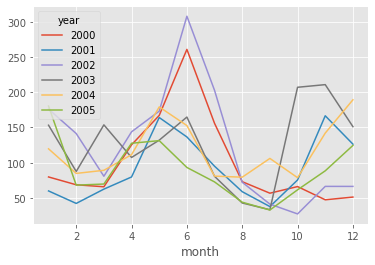

In [17]:
pd.pivot_table(df, index='month', columns='year', values='streamflow').plot()

Oder als Säulendiagramm:

<AxesSubplot:xlabel='month'>

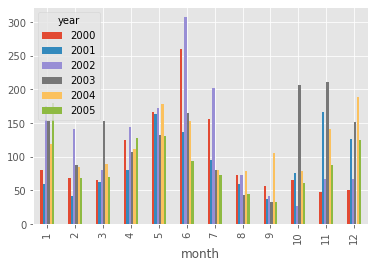

In [18]:
pd.pivot_table(df, index='month', columns='year', values='streamflow').plot(kind='bar')

Die nachfolgende Funktion kapselt die oben beschriebene Logik, sowohl für den Abfluss als auch für den Niederschlag:

In [19]:
def calc_and_plot_monthly_means(df_streamflow: pd.DataFrame, df_forcings: pd.DataFrame, start_date: int, end_date: int):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    # Discharge
    means = df_streamflow["streamflow"].groupby(
        [df_streamflow.index.year, df_streamflow.index.month]).mean()

    df = means.loc[start_date:end_date].to_frame()
    df.index = df.index.set_names(["year", "month"])
    df.reset_index(inplace=True)

    ax1 = pd.pivot_table(df, index='month', columns='year', values='streamflow').plot(kind='bar', ax=ax1)
    ax1.set_xticklabels(month_names, rotation=45)
    ax1.set_xlabel('Monat')
    ax1.set_ylabel('Durchschnittlicher Durchfluss [m$^3$/s]')
    ax1.legend(title='Jahr')

    means = df_forcings["prcp(mm/day)"].groupby(
        [df_forcings.index.year, df_forcings.index.month]).mean()

    df = means.loc[start_date:end_date].to_frame()
    df.index = df.index.set_names(["year", "month"])
    df.reset_index(inplace=True)

    # Niederschlag
    ax2 = pd.pivot_table(df, index='month', columns='year', values='prcp(mm/day)').plot(kind='bar', ax=ax2)
    ax2.set_xticklabels(month_names, rotation=45)
    ax2.set_xlabel('Monat')
    ax2.set_ylabel('Durchschnittlicher Niederschlag [mm/d]')
    ax2.legend(title='Jahr')

So lassen sich für beliebige Zeiträume die monatlichen Mittelwerte gegenüberstellen:

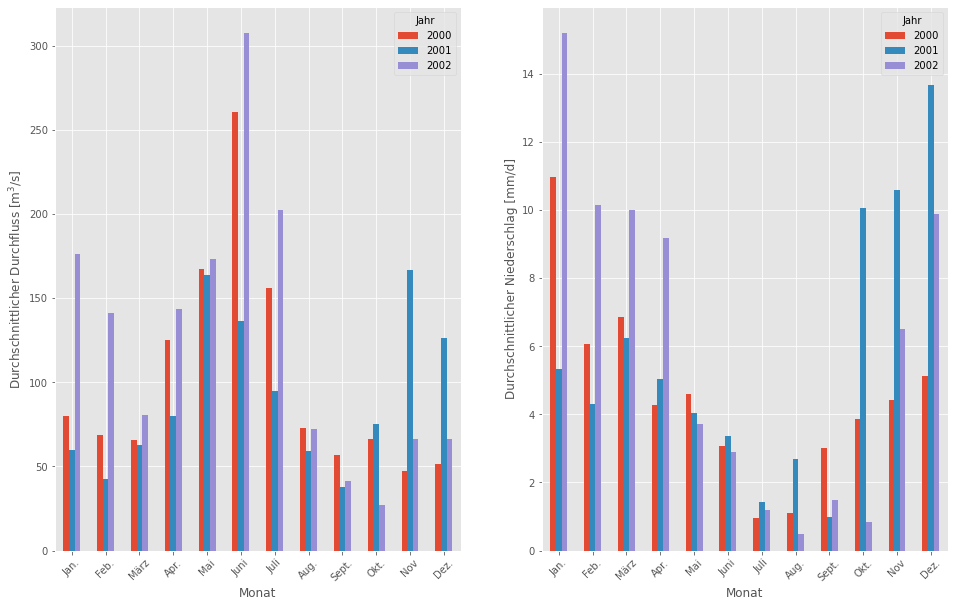

In [20]:
calc_and_plot_monthly_means(df_streamflow, df_forcings, 2000, 2002)

## Temporale Trendanalyse

Für die Trendanalyse, bestimmen wir eine Regressionsgrade für einen ausgewählten Parameter durch lineare Regression. Die x-Werte bilden hierbei die aufsteigenden Indizes des DataFrames (Datums-Indizes müssen zunächst in numerische Werte umgewandelt werden) und die y-Werte, die jeweiligen Parameterwerte.

In [21]:
x = df_streamflow.reset_index().index
y = df_streamflow["streamflow"]
regr_streamflow = stats.linregress(x, y)


Mit dem y-Achsenabschnitt und der Steigung der Regressionsgrade, lässt sich diese grafischen darstellen

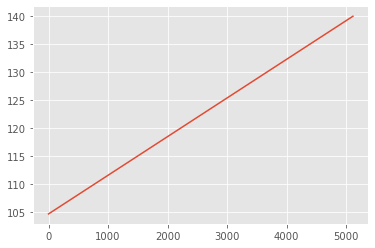

In [22]:
plt.plot(x, regr_streamflow.intercept + regr_streamflow.slope * x, label ='Regressionsgrade')

Die nachfolgende Funktion fasst beide Schritte zusammen.

In [23]:
def calc_and_plot_regression(df, col_name, ax, flag_max):
    x = df.reset_index().index
    y = df[col_name]
    regr_streamflow = stats.linregress(x, y)

    df_max = df[col_name].groupby(df.index.year).max()
    if flag_max:
        ax.plot(df_max, label='Max. Werte')
        ax.plot(df_max.index, regr_streamflow.intercept + regr_streamflow.slope * df_max.index,
                label='Regressionsgrade')
    else:
        ax.plot(x, regr_streamflow.intercept + regr_streamflow.slope * x,
                label='Regressionsgrade')
    ax.set_xlabel('Monat')
    ax.legend()

Text(0, 0.5, 'Max. Temperatur [°C]')

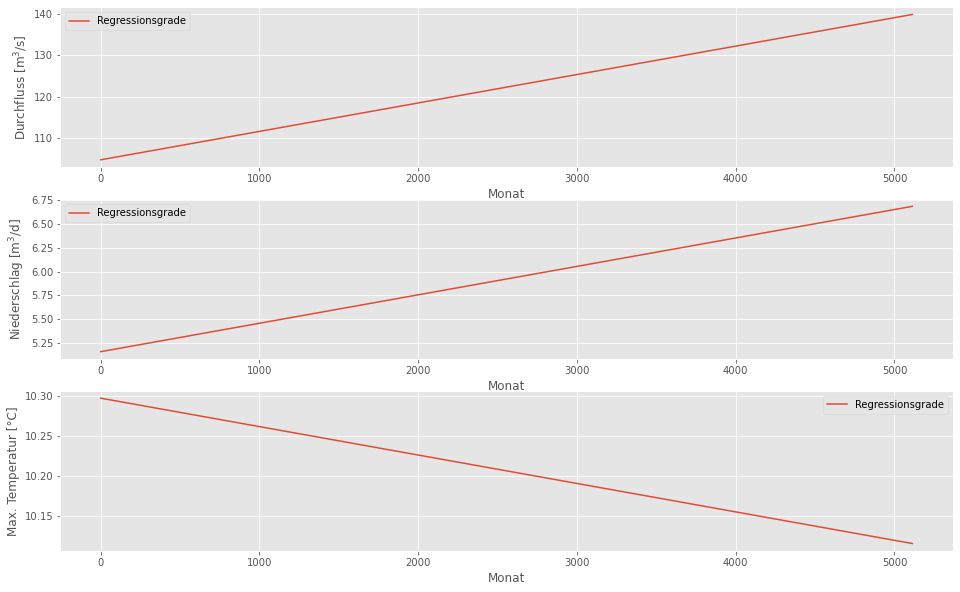

In [24]:
plot_max_values = False
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
calc_and_plot_regression(df_streamflow, "streamflow", ax1, plot_max_values)
ax1.set_ylabel("Durchfluss [m$^3$/s]")
calc_and_plot_regression(df_forcings, "prcp(mm/day)", ax2, plot_max_values)
ax2.set_ylabel("Niederschlag [m$^3$/d]")
calc_and_plot_regression(df_forcings, "tmax(C)", ax3, plot_max_values)
ax3.set_ylabel("Max. Temperatur [°C]")

## Korrelationsanalyse

Für die Korrelationsanalyse müssen zunächst für jeden aktuellen Abflusswert, die Niederschlagswerte der n-letzten Tage ermittelt werden. Dies lässt sich vollständig mit pandas-Funktionen umsetzen, sodass umständlichen Schleifen vermieden werden.

In [25]:
n_days = 3
index = df_streamflow.reset_index().index[n_days:]

df_sel_streamflow = df_streamflow.iloc[index]
df_sel_streamflow["prcp_actual"] = df_forcings["prcp(mm/day)"].iloc[index].tolist()
df_sel_streamflow["prcp_offset_1"] = df_forcings["prcp(mm/day)"].iloc[index - 1].tolist()
df_sel_streamflow["prcp_offset_2"] = df_forcings["prcp(mm/day)"].iloc[index - 2].tolist()
df_sel_streamflow["prcp_offset_3"] = df_forcings["prcp(mm/day)"].iloc[index - 3].tolist()

Für jeden der n-letzten Tage wurde so eine separate Spalte mit den entsprechenden Niederschlagswerten angelegt

In [26]:
df_sel_streamflow

,gauge_id,streamflow,qc_flag,streamflow_unconverted,prcp_actual,prcp_offset_1,prcp_offset_2,prcp_offset_3
date,,,,,,,,
2000-01-04,12189500,143.848223,A,5080.0,33.81,17.93,15.20,26.38
2000-01-05,12189500,135.070084,A,4770.0,8.43,33.81,17.93,15.20
2000-01-06,12189500,109.585162,A,3870.0,6.42,8.43,33.81,17.93
2000-01-07,12189500,97.125867,A,3430.0,8.62,6.42,8.43,33.81
2000-01-08,12189500,118.929633,A,4200.0,39.97,8.62,6.42,8.43
...,...,...,...,...,...,...,...,...
2013-12-27,12189500,75.605267,A,2670.0,0.00,1.45,0.00,14.27
2013-12-28,12189500,82.118080,A,2900.0,7.42,0.00,1.45,0.00
2013-12-29,12189500,73.906272,A,2610.0,2.21,7.42,0.00,1.45


Zur Berechnung einer Korrelationsmatrix gibt es in pandas die [pandas.DataFrame.corr Funktion](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html). Diese berechnet für alle angegebenen Spalten eine paarweise Korrelation. Anahnd der Korrelationswerte lässt sich erkennen, dass für einen aktuellen Abflusswert die höchste Korrelation mit dem Niederschlag des letzten Tages (_prcp_offset_1_) vorliegt.

In [27]:
df_sel_streamflow[["streamflow", "prcp_actual", "prcp_offset_1", "prcp_offset_2",  "prcp_offset_3"]].corr()

,streamflow,prcp_actual,prcp_offset_1,prcp_offset_2,prcp_offset_3
streamflow,1.000000,0.399370,0.438409,0.268796,0.190791
prcp_actual,0.399370,1.000000,0.622478,0.329243,0.257516
prcp_offset_1,0.438409,0.622478,1.000000,0.622552,0.329552
prcp_offset_2,0.268796,0.329243,0.622552,1.000000,0.622611
prcp_offset_3,0.190791,0.257516,0.329552,0.622611,1.000000
